In [1]:
## Prior shift testing 

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import requests
import zipfile
import tarfile
import cv2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import wasserstein_distance
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from torch import no_grad
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class LungBiopsyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(root_dir))

        for label_idx, class_name in enumerate(self.class_names):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            for file in os.listdir(class_path):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_path, file))
                    self.labels.append(label_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # === Apply CLAHE ===
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)
        merged = cv2.merge((cl, a, b))
        image = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label


In [4]:
# ImageNet-style normalization
img_size = 224
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ✅ Paths (update only if your folder names differ)
train_path = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets"
external_path = "/kaggle/input/listhist700forpriortesting/external_data"

# Load datasets
train_dataset = LungBiopsyDataset(train_path, transform=transform)
external_dataset = LungBiopsyDataset(external_path, transform=transform)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
external_loader = DataLoader(external_dataset, batch_size=32, shuffle=False)

print("Code block ran successfully")


Code block ran successfully


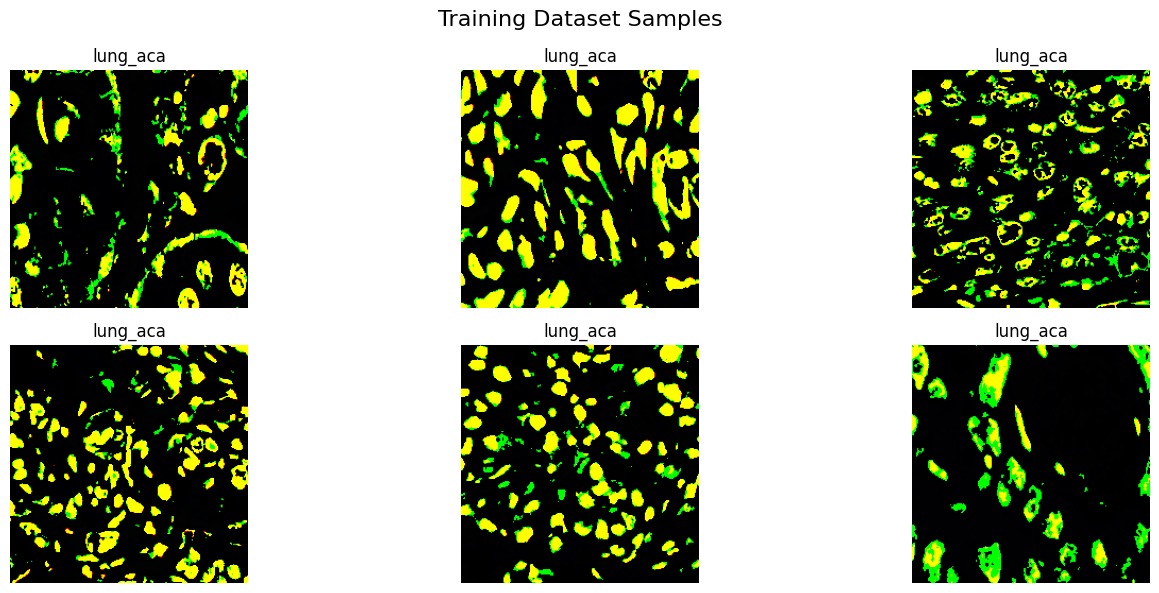

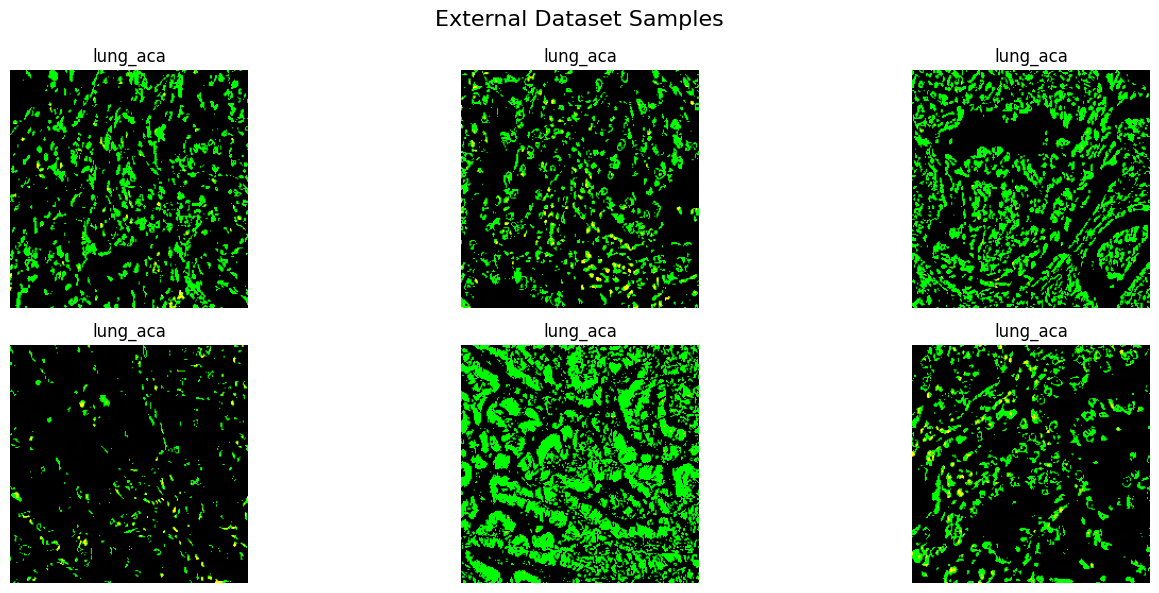

In [5]:
def show_sample_images(dataloader, class_names, title, num_images=6):
    import matplotlib.pyplot as plt

    images_shown = 0
    plt.figure(figsize=(15, 6))
    
    for images, labels in dataloader:
        for i in range(len(images)):
            image = images[i].numpy().transpose(1, 2, 0)
            label = class_names[labels[i].item()]
            
            plt.subplot(2, num_images // 2, images_shown + 1)
            plt.imshow(image.astype('uint8'))
            plt.title(label)
            plt.axis('off')
            
            images_shown += 1
            if images_shown == num_images:
                plt.suptitle(title, fontsize=16)
                plt.tight_layout()
                plt.show()
                return


class_names = train_dataset.class_names

# Show 6 training images
show_sample_images(train_loader, class_names, title="Training Dataset Samples")


# Show 6 external test images
show_sample_images(external_loader, class_names, title="External Dataset Samples")


In [6]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import os
from collections import Counter

def get_labels_from_directory(root_dir):
    """
    Extract labels from directory structure.
    Assumes that subdirectories' names are the labels.
    
    Args:
        root_dir (str): Path to the root directory containing subdirectories.
        
    Returns:
        list: List of labels based on subdirectory names.
    """
    labels = []
    for subdir in os.listdir(root_dir):
        subdir_path = os.path.join(root_dir, subdir)
        if os.path.isdir(subdir_path):
            labels.append(subdir)  # Using folder name as label
    return labels

def chi_square_test_for_label_distribution(train_root_dir, external_root_dir):
    """
    Conducts a Chi-Square test to compare label distributions between training and external datasets.
    
    Args:
        train_root_dir (str): Root directory of the training dataset.
        external_root_dir (str): Root directory of the external dataset.
        
    Returns:
        chi2_stat: Chi-Square statistic.
        p_value: p-value from the Chi-Square test.
    """
    # Step 1: Get labels from directories
    train_labels = get_labels_from_directory(train_root_dir)
    external_labels = get_labels_from_directory(external_root_dir)

    # Step 2: Count labels using Counter
    train_counter = Counter(train_labels)
    external_counter = Counter(external_labels)

    # Step 3: Ensure all possible labels are accounted for
    all_labels = sorted(set(train_counter.keys()).union(set(external_counter.keys())))
    
    # Step 4: Create observed frequency table
    observed = np.array([
        [train_counter.get(label, 0) for label in all_labels],
        [external_counter.get(label, 0) for label in all_labels]
    ])

    # Step 5: Conduct Chi-Square test
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(observed)

    # Step 6: Interpretation of the result
    print(f"Chi-Square Statistic: {chi2_stat}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print("There is a significant difference in label distributions (Prior Shift).")
    else:
        print("There is no significant difference in label distributions (No Prior Shift).")
    
    return chi2_stat, p_value

# Example Usage
train_root_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'  # Replace with the path to your training dataset
external_root_dir = '/kaggle/input/listhist700forpriortesting/external_data'  # Replace with the path to your external dataset

# Run the Chi-Square test
chi2_stat, p_value = chi_square_test_for_label_distribution(train_root_dir, external_root_dir)


Chi-Square Statistic: 9.0
P-value: 0.34229595583459105
There is no significant difference in label distributions (No Prior Shift).


In [11]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import os
from collections import Counter

def get_labels_from_directory(root_dir):
    """
    Extract labels from directory structure.
    Assumes that subdirectories' names are the labels.
    
    Args:
        root_dir (str): Path to the root directory containing subdirectories.
        
    Returns:
        list: List of labels based on subdirectory names.
    """
    labels = []
    for subdir in os.listdir(root_dir):
        subdir_path = os.path.join(root_dir, subdir)
        if os.path.isdir(subdir_path):
            labels.append(subdir)  # Using folder name as label
    return labels

def chi_square_test_for_label_distribution(train_root_dir, external_root_dir):
    """
    Conducts a Chi-Square test to compare label distributions between training and external datasets.
    
    Args:
        train_root_dir (str): Root directory of the training dataset.
        external_root_dir (str): Root directory of the external dataset.
        
    Returns:
        chi2_stat: Chi-Square statistic.
        p_value: p-value from the Chi-Square test.
    """
    # Step 1: Get labels from directories
    train_labels = get_labels_from_directory(train_root_dir)
    external_labels = get_labels_from_directory(external_root_dir)

    # Step 2: Count labels using Counter
    train_counter = Counter(train_labels)
    external_counter = Counter(external_labels)

    # Step 3: Ensure all possible labels are accounted for
    all_labels = sorted(set(train_counter.keys()).union(set(external_counter.keys())))
    
    # Step 4: Create observed frequency table
    observed = np.array([
        [train_counter.get(label, 0) for label in all_labels],
        [external_counter.get(label, 0) for label in all_labels]
    ])

    # Step 5: Conduct Chi-Square test
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(observed)

    # Step 6: Interpretation of the result
    print(f"Chi-Square Statistic: {chi2_stat}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print("There is a significant difference in label distributions (Prior Shift).")
    else:
        print("There is no significant difference in label distributions (No Prior Shift).")
    
    return chi2_stat, p_value

# Example Usage
train_root_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'  # Replace with the path to your training dataset
external_root_dir = '/kaggle/input/listhist700forpriortesting/external_data'  # Replace with the path to your external dataset

# Run the Chi-Square test
chi2_stat, p_value = chi_square_test_for_label_distribution(train_root_dir, external_root_dir)


Chi-Square Statistic: 9.999999999999996
P-value: 0.3504852123233621
There is no significant difference in label distributions (No Prior Shift).


In [10]:

from collections import Counter

def get_labels_from_directory(root_dir):
    """
    Extract labels from directory structure.
    Assumes that subdirectories' names are the labels.
    
    Args:
        root_dir (str): Path to the root directory containing subdirectories.
        
    Returns:
        list: List of labels based on subdirectory names.
    """
    labels = []
    for subdir in os.listdir(root_dir):
        subdir_path = os.path.join(root_dir, subdir)
        if os.path.isdir(subdir_path):
            labels.append(subdir)  # Using folder name as label
    return labels

def kl_divergence(train_root_dir, external_root_dir):
    """
    Calculates the Kullback-Leibler divergence between the label distributions 
    of the training and external datasets.
    
    Args:
        train_root_dir (str): Root directory of the training dataset.
        external_root_dir (str): Root directory of the external dataset.
        
    Returns:
        kl_divergence: KL Divergence score.
    """
    # Step 1: Get labels from directories
    train_labels = get_labels_from_directory(train_root_dir)
    external_labels = get_labels_from_directory(external_root_dir)

    # Step 2: Count labels using Counter
    train_counter = Counter(train_labels)
    external_counter = Counter(external_labels)

    # Step 3: Ensure all possible labels are accounted for
    all_labels = sorted(set(train_counter.keys()).union(set(external_counter.keys())))

    # Step 4: Convert counts to probabilities
    total_train_samples = len(train_labels)
    total_external_samples = len(external_labels)

    train_probabilities = {label: train_counter.get(label, 0) / total_train_samples for label in all_labels}
    external_probabilities = {label: external_counter.get(label, 0) / total_external_samples for label in all_labels}

    # Step 5: Calculate KL Divergence
    kl_div = 0.0
    for label in all_labels:
        p = train_probabilities[label]
        q = external_probabilities[label]
        if p > 0 and q > 0:
            kl_div += p * np.log(p / q)  # KL divergence formula

    return kl_div

# Example Usage
train_root_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'  # Replace with the path to your training dataset
external_root_dir = '/kaggle/input/listhist700forpriortesting/external_data'  # Replace with the path to your external dataset

# Calculate KL Divergence
kl_div = kl_divergence(train_root_dir, external_root_dir)

# Print the result
print(f"KL Divergence: {kl_div}")


KL Divergence: 0.0
